In [21]:
import pandas as pd
import numpy as np

import os
import re

# get the list of files and directories in the raw data  directory
directory = 'Data/Nb_Strip/'
text_files = os.listdir(directory)

data_list = []


# add the data to each sample
for file in text_files:
    data = pd.read_csv(directory+file,delimiter='\t').drop('Unnamed: 6', axis=1)
    data = data[data['freq/Hz']!=0.0]
    data = data.astype({'cycle number': int})
    
    data_list.append(data)

In [22]:
from scipy.special import hermite
import matplotlib.pyplot as plt

def Gaussian_Func(x,sigma):
    y = np.exp(-x**2/(2*sigma**2)) / (2.5066282*sigma)
    return y

def Gaussian_Derivative(x,n,sigma):
    hermite_poly = hermite(n)
    y = (-1)**n * Gaussian_Func(x,sigma) * hermite_poly(x/(1.41421356*sigma))
    return y

def quad(f, a, b, n=5):
    # Generate the quadrature rule coefficients
    x, w = np.polynomial.legendre.leggauss(n)
    
    # Scale the quadrature points and weights to the interval [a, b]
    x_scaled = 0.5 * (b - a) * x + 0.5 * (b + a)
    w_scaled = 0.5 * (b - a) * w
    
    # Evaluate the function at the quadrature points and sum up the weighted contributions
    integral = np.sum(w_scaled[:,None] * f(x_scaled),axis=0)
    
    return integral

def re_integrand(x, fn, fm, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Func(x, gaussian_sigma)[:,None] / (1 + np.exp(-2 * x_diff))

def im_integrand(x, fn, fm, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Func(x, gaussian_sigma)[:,None] * np.exp(-x_diff) / (1 + np.exp(-2 * x_diff))

def norm_integrand(x, fn, fm, k, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Derivative(x_diff,k,gaussian_sigma)*Gaussian_Derivative(x,k,gaussian_sigma)[:,None]

def integrate_test_functions(log_fm,log_fn,gaussian_sigma):

    #Integrate the test functions
    fn_mesh, fm_mesh = np.meshgrid(log_fm, log_fn, indexing='ij')
    
    # reshape fn_mesh and fm_mesh into column vectors
    fn = fn_mesh.flatten()
    fm = fm_mesh.flatten()
    
    #Real integral
    # integral = np.array([quad(lambda y: Gaussian_Func(y,gaussian_sigma)*1/(1+np.exp(-2*(y-fn+fm))), -3*gaussian_sigma, 3*gaussian_sigma) for fn, fm in zip(fn_mesh.flatten(), fm_mesh.flatten())])
    integral = quad(lambda y: re_integrand(y,fn,fm,gaussian_sigma), -3*gaussian_sigma, 3*gaussian_sigma)
                                   
    A_re = integral.reshape(fn_mesh.shape)
    
    #Imag integral
    # integral = np.array([quad(lambda y: Gaussian_Func(y,gaussian_sigma)*np.exp(-(y-fn+fm))/(1+np.exp(-2*(y-fn+fm))), -3*gaussian_sigma, 3*gaussian_sigma) for fn, fm in zip(fn_mesh.flatten(), fm_mesh.flatten())])    
    integral = quad(lambda y: im_integrand(y,fn,fm,gaussian_sigma), -3*gaussian_sigma, 3*gaussian_sigma)
    
    A_im = integral.reshape(fn_mesh.shape)
    
    return A_re, A_im

def Fit_Function_2(params, A_re, A_im, f_m, derivative = 0):
    x = params[0:-3]
    C = params[-3]

    R = params[-2]
    L = params[-1]


    if derivative == 1:

        jac_re = np.zeros((f_m.shape[0],params.shape[0]))
        jac_im = np.zeros((f_m.shape[0],params.shape[0]))

        jac_re[:,0:-3] = A_re
        jac_im[:,0:-3] = A_im
        jac_re[:,-2] = np.ones((f_m.shape[0]))
        jac_im[:,-3] = -np.exp(-f_m)
        jac_im[:,-1] = np.exp(f_m)

        return jac_re, jac_im

    else:
        Z_sim_re = np.matmul(A_re,x)+R
        Z_sim_im = np.matmul(A_im,x)+np.exp(f_m)*L-np.exp(-f_m)*C
        return Z_sim_re, Z_sim_im

def Fit_Function_1(params, A_re, A_im, f_m, derivative = 0):
    x = params[0:-4]
    w = np.exp(f_m)
    w_o = np.exp(params[-3])
    R2 = params[-4]

    R1 = params[-2]
    L = params[-1]


    if derivative == 1:

        jac_re = np.zeros((f_m.shape[0],params.shape[0]))
        jac_im = np.zeros((f_m.shape[0],params.shape[0]))

        dR2_re = 1/(1+(w/w_o)**2)
        dR2_im = (-w/w_o)/(1+(w/w_o)**2)

        dw_o_re = (-1/w_o**2)*(-2*R2*w/w_o)/(1+(w/w_o)**2)**2
        dw_o_im = (-1/w_o**2)*((2*w**2/w_o)/(1+(w/w_o)**2)**2-w/(1+(w/w_o)**2))

        jac_re[:,0:-4] = A_re
        jac_im[:,0:-4] = A_im
        jac_re[:,-2] = np.ones((f_m.shape[0]))
        jac_re[:,-3] = dw_o_re
        jac_im[:,-3] = dw_o_im
        jac_re[:,-4] = dR2_re
        jac_im[:,-4] = dR2_im
        jac_im[:,-1] = np.exp(f_m)

        return jac_re, jac_im

    else:

        Z_RC_re = R2/(1+(w/w_o)**2)
        Z_RC_im = (-R2*w/w_o)/(1+(w/w_o)**2)

        Z_sim_re = np.matmul(A_re,x)+R1+Z_RC_re
        Z_sim_im = np.matmul(A_im,x)+np.exp(f_m)*L+Z_RC_im

        return Z_sim_re, Z_sim_im
    

def generalized_DRT(params, A_re, A_im, f_m, derivative = 0):
    x_re = params[0:A_re.shape[1]]
    x_im = params[A_re.shape[1]:A_re.shape[1]+A_im.shape[1]]

    R1 = params[-2]
    L = params[-1]


    if derivative == 1:

        jac_re = np.zeros((f_m.shape[0],params.shape[0]))
        jac_im = np.zeros((f_m.shape[0],params.shape[0]))


        jac_re[:A_re.shape[0],:A_re.shape[1]] = A_re
        jac_im[:A_im.shape[0],:A_im.shape[1]] = A_im
        jac_re[:,-2] = np.ones((f_m.shape[0]))
        jac_im[:,-1] = np.exp(f_m)

        return jac_re, jac_im

    else:

        Z_sim_re = np.matmul(A_re,x_re)+R1
        Z_sim_im = np.matmul(A_im,x_im)+np.exp(f_m)*L

        return Z_sim_re, Z_sim_im    

from scipy.optimize import lsq_linear, minimize

def cost_func(params,f_m,A_re,A_im,b,norm_matrix,fit_function):

    #DRT_params = A_re.shape[1]
    
    x = params
    
    Z_sim_re, Z_sim_im = fit_function(params,A_re,A_im,f_m)


    Z_exp_re = np.real(b)
    Z_exp_im = np.imag(b)


    
    Re_cost = np.linalg.norm((Z_exp_re-Z_sim_re))
    Im_cost = np.linalg.norm((Z_exp_im-Z_sim_im))
    Re_norm_cost = (np.matmul(x,np.matmul(norm_matrix,x.T)))
    Im_norm_cost = (np.matmul(x,np.matmul(norm_matrix,x.T)))
    
    cost = Re_cost + Im_cost + Re_norm_cost + Im_norm_cost

    return cost

def cost_func_jac(params,f_m,A_re,A_im,b,norm_matrix,fit_function):
        
    #DRT_params = A_re.shape[1]

    Z_sim_re, Z_sim_im = fit_function(params,A_re,A_im,f_m)

    dZ_sim_re, dZ_sim_im = fit_function(params,A_re,A_im,f_m,derivative=1)

    Z_exp_re = np.real(b)
    Z_exp_im = np.imag(b)

    dRe_cost = -2*np.sum((Z_exp_re-Z_sim_re)[:,None]*dZ_sim_re,axis=0)
    dIm_cost = -2*np.sum((Z_exp_im-Z_sim_im)[:,None]*dZ_sim_im,axis=0)
    
    x = params

    
    dRe_norm_cost = np.zeros((params.shape[0]))
    dIm_norm_cost = np.zeros((params.shape[0]))
    
    dRe_norm_cost = np.matmul(x,norm_matrix)+np.matmul(norm_matrix,x.T)
    dIm_norm_cost = np.matmul(x,norm_matrix)+np.matmul(norm_matrix,x.T)

    dcost = dRe_cost + dRe_norm_cost + dIm_cost + dIm_norm_cost

    return dcost

def DRT_Fit(measured_frequencies, measured_Z, fitting_frequencies, reg_params, R0, L0, C0):
    
    f_m = measured_frequencies
    f_n = fitting_frequencies
    Z_m = measured_Z
       
    reg_order = reg_params.shape[0]
    gaussian_width = (np.max(fitting_frequencies)-np.min(fitting_frequencies))/fitting_frequencies.shape[0]
        
    #Generate parameter array
    #real, imag, resistance, inductance
    x_params = np.zeros((fitting_frequencies.shape[0]+4))
    x_params[-4] = 0.0
    x_params[-3] = 0.0
    x_params[-2] = R0
    x_params[-1] = L0
    
    #Integrate the test functions wrt the measured frequencies
    A_re, A_im = integrate_test_functions(measured_frequencies, fitting_frequencies, gaussian_width/2.355)
    
    #Calculate the regularization matrix
    fn_mesh, fm_mesh = np.meshgrid(f_n, f_n, indexing='ij')
    
    fn = fn_mesh.flatten()
    fm = fm_mesh.flatten()
    
    M = np.zeros((x_params.shape[0],x_params.shape[0]))
    for k in range(reg_order):
        integral = quad(lambda y: norm_integrand(y,fn,fm,k,gaussian_width/2.355), -3*gaussian_width/2.355, 3*gaussian_width/2.355)
        M[:fitting_frequencies.shape[0],:fitting_frequencies.shape[0]] += reg_params[k]*integral.reshape(fn_mesh.shape).T
    
    
    #Fit to experimental data
    b = Z_m
    
    #Solve for parameters
    res = minimize(cost_func,x_params,args=(f_m,A_re,A_im,b,M,Fit_Function_1),method='BFGS',jac=cost_func_jac)
    x_params = res['x']
    
    #Calculate the gamma function coefficients
    x = x_params[:-4]
    #x_im = x_re
    w_o = x_params[-3]
    R1 = x_params[-2]
    R2 = x_params[-4]
    L = x_params[-1]
    
    return {'x': x, 
            'R1': R1,
            'R2': R2,
            'L': L,
            'w_o': w_o,
            'A_re': A_re,
            'A_im': A_im,
            'f_m': f_m,
            'params': x_params}






def Bode_Plot(data,title=None):

    
    fig, ax = plt.subplots(2,1,figsize = (4,5),dpi=200)

    ax[0].set_title(title)
    
    for key in data.keys():
        cycle_data = data[key]

    
        freq = cycle_data['Freq']
        ReZ = cycle_data['ReZ']
        ImZ = cycle_data['Imz']
        ax[0].plot(freq,ReZ,lw=0.5)
        ax[1].plot(freq,ImZ,lw=0.5)

        
    if Z_exp is not None:
        freq = Z_exp[0]
        ReZ = np.real(Z_exp[1])
        ImZ = np.imag(Z_exp[1])
        ax[0].scatter(freq,ReZ,s=5,marker='x',lw=0.5)
        ax[1].scatter(freq,ImZ,s=5,marker='x',lw=0.5)

    ax[0].set_xscale('log')
    # ax[0].set_xlabel('Frequency [rad/s]')
    ax[0].set_ylabel('Real Impedence [Ohm]')
        
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Frequency [rad/s]')
    ax[1].set_ylabel('Imaginary Impedence [Ohm]')
    
    plt.tight_layout()

In [23]:
"""Model Fitting"""






import time

output = {}

#Generate regularization hyper-parameter array
reg_params = np.array((5e-2,5e-2,5e-3))

for row, data in enumerate(data_list[0:1]):    

    for cycle in range(data['cycle number'].max()):
    #for cycle in range(10):


        cycle_data = data[data['cycle number'] == cycle+1]

        #Load data
        Freq = np.array(cycle_data['freq/Hz'])
        ReZ = np.array(cycle_data['Re(Z)/Ohm'])
        ImZ = np.array(cycle_data['-Im(Z)/Ohm'])
        Z = ReZ + 1j*ImZ




        #PARAMS
        f_min = np.min(Freq)/1000
        f_max = np.max(Freq)
        fitting_params_per_decade = 12


        #Convert to log frequency
        log_f_min = np.log(f_min)
        log_f_max = np.log(f_max)

        #Generate the fitting test function offsets
        number_of_fitting_params = int(fitting_params_per_decade*(log_f_max-log_f_min))
        log_f_n = np.linspace(log_f_min,log_f_max,number_of_fitting_params)
        gaussian_width = (np.max(log_f_n)-np.min(log_f_n))/log_f_n.shape[0]

        #Convert experimental frequencies to log space
        log_Freq = np.log(Freq)
  
        

        
        # start the timer
        start_time = time.time()
        
        output[f'Data {row} Cycle {cycle}'] = DRT_Fit(log_Freq, Z, log_f_n, reg_params,2.0,0.0,0.0)
        output[f'Data {row} Cycle {cycle}']['E'] = np.array(cycle_data['<Ewe>/V'])
        output[f'Data {row} Cycle {cycle}']['I'] = np.array(cycle_data['<I>/mA'])
        output[f'Data {row} Cycle {cycle}']['ReZ'] = ReZ
        output[f'Data {row} Cycle {cycle}']['ImZ'] = ImZ
        output[f'Data {row} Cycle {cycle}']['Freq'] = Freq
        

        # end the timer
        end_time = time.time()
        
        # calculate the elapsed time
        elapsed_time = end_time - start_time
        
        # print the elapsed time
        print("Elapsed time: {:.2f} seconds".format(elapsed_time))



import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.transforms import Bbox

"""Plotting"""

x = []
Electrode_Potential = []
Current = []
Current_min = []
Current_max = []

#fig, (ax) = plt.subplots()
#ax.set_xlim(0.6,1.2)
#ax.set_ylim(-0.2,0.3)

for key in output.keys():



    cycle_output = output[key]

#    ax.scatter(cycle_output['ReZ'],cycle_output['ImZ'])
#    ax.plot(np.matmul(cycle_output['A_re'],cycle_output['x'])+cycle_output['R'],np.matmul(cycle_output['A_im'],cycle_output['x'])+np.exp(cycle_output['f_m'])*cycle_output['L']-np.exp(-cycle_output['f_m'])*cycle_output['C'])


    x.append(cycle_output['x'])
    Electrode_Potential.append(cycle_output['E'][-1])
    Current.append(np.mean(cycle_output['I']))
    Current_max.append(np.max(cycle_output['I']))
    Current_min.append(np.min(cycle_output['I']))

x = np.array(x).T
Electrode_Potential = np.array(Electrode_Potential)
Current = np.array(Current)
Current_max = np.array(Current_max)
Current_min = np.array(Current_min)


Elapsed time: 0.10 seconds
Elapsed time: 0.14 seconds
Elapsed time: 0.12 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.13 seconds
Elapsed time: 0.13 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.14 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.40 seconds
Elapsed time: 0.25 seconds
Elapsed time: 0.14 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.20 seconds
Elapsed time: 0.13 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.13 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.12 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.17 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.11 seconds
Elapsed time: 0.18 seconds
Elapsed time: 0.11 seconds
E

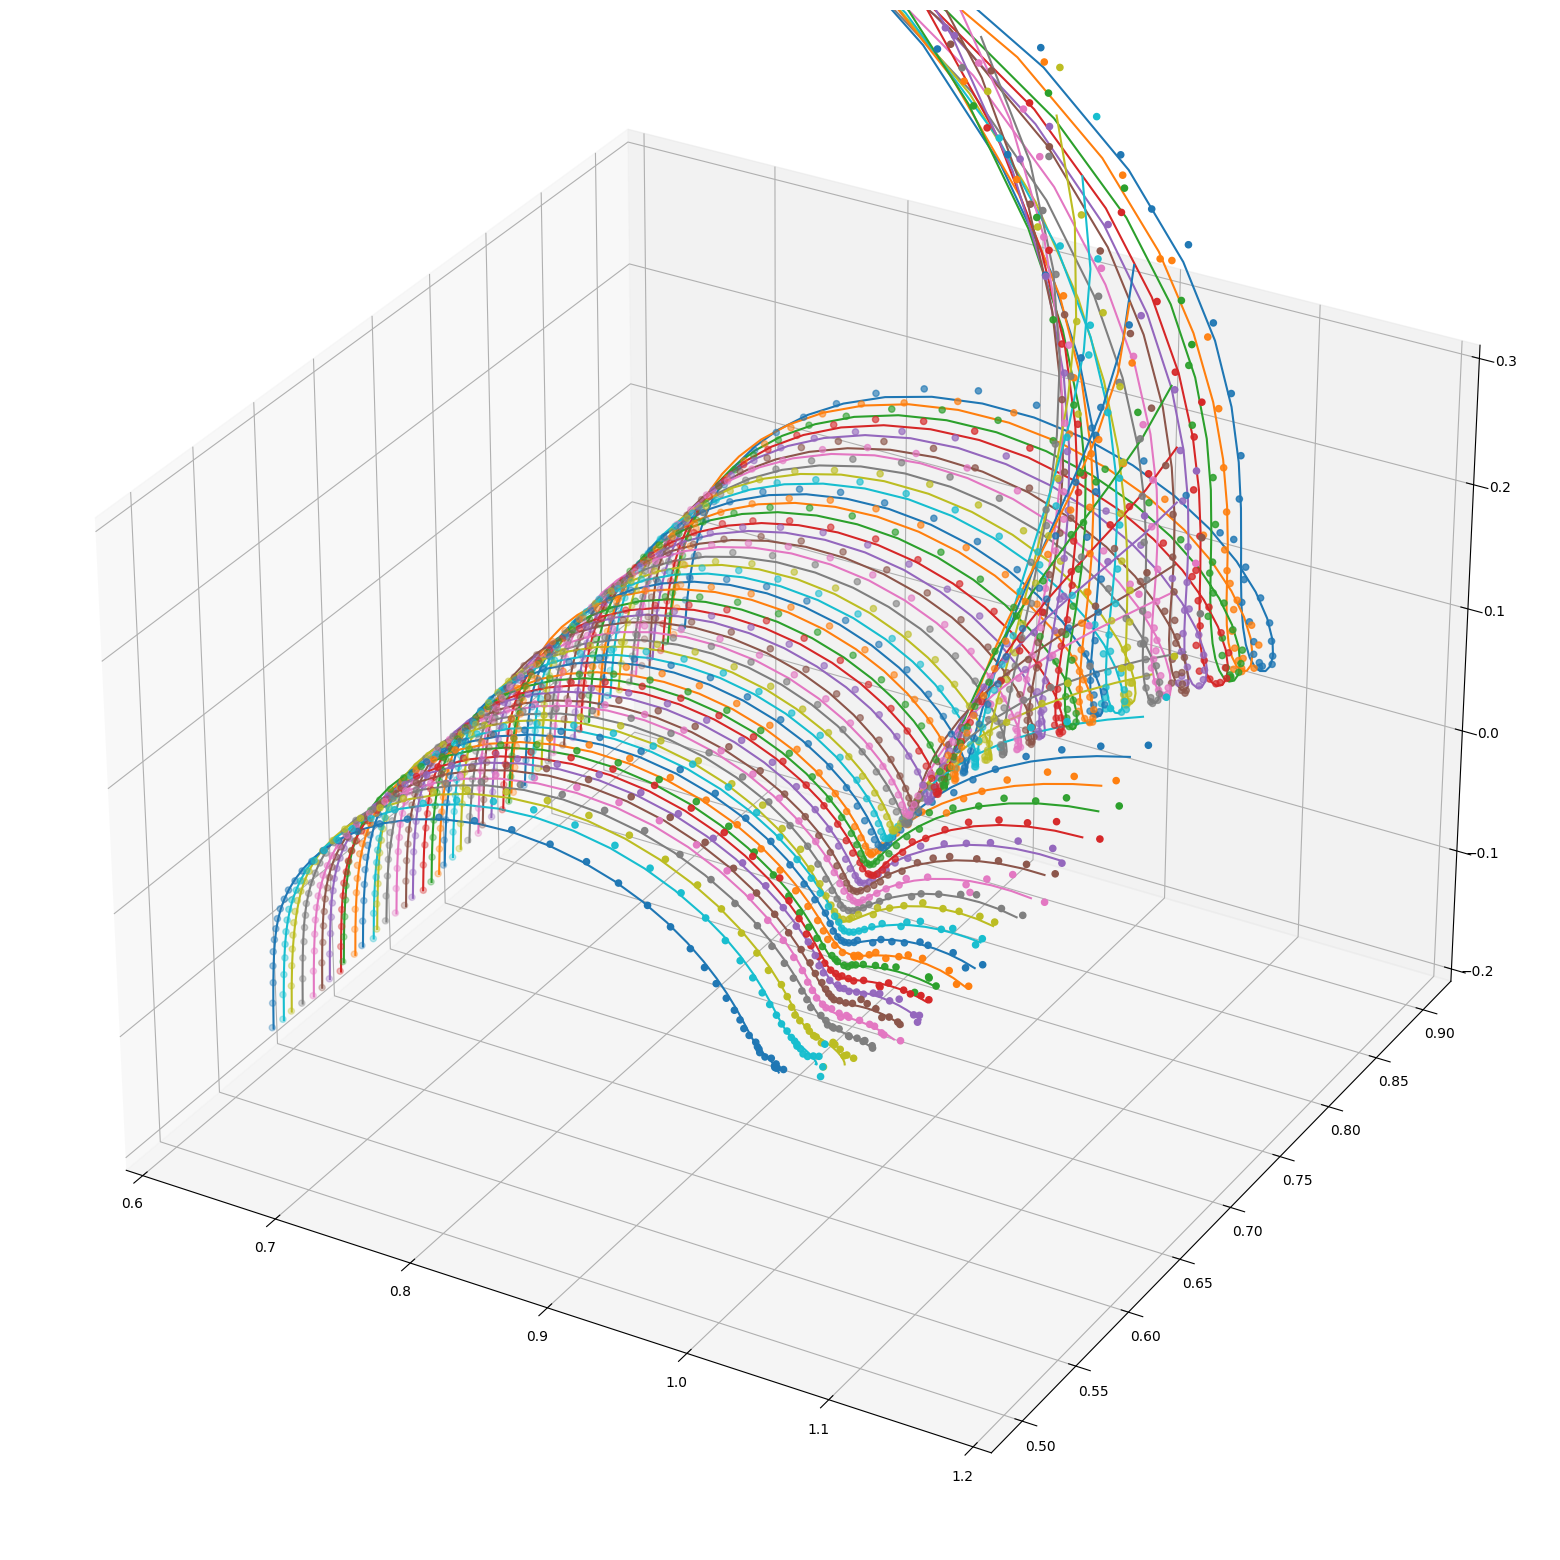

In [24]:
ax = plt.figure(figsize=(20,20)).add_subplot(projection='3d')

ax.set_xlim(0.6,1.2)
ax.set_zlim(-0.2,0.3)

for i, key in reversed(list(enumerate(output.keys()))):
    cycle_output = output[key]

    
    Z_exp_re = cycle_output['ReZ']
    Z_exp_im = cycle_output['ImZ']
    #Z_sim_re = np.matmul(cycle_output['A_re'],cycle_output['x'])+cycle_output['R']
    #Z_sim_im = np.matmul(cycle_output['A_im'],cycle_output['x'])+np.exp(cycle_output['f_m'])*cycle_output['L']-np.exp(-cycle_output['f_m'])*cycle_output['C']

    Z_sim_re, Z_sim_im = Fit_Function_1(cycle_output['params'], cycle_output['A_re'], cycle_output['A_im'], cycle_output['f_m'])

    ax.scatter(Z_exp_re,Electrode_Potential[i].repeat(Z_exp_re.shape[0]),Z_exp_im)
    ax.plot(Z_sim_re,Electrode_Potential[i].repeat(Z_sim_re.shape[0]),Z_sim_im)



plt.show()





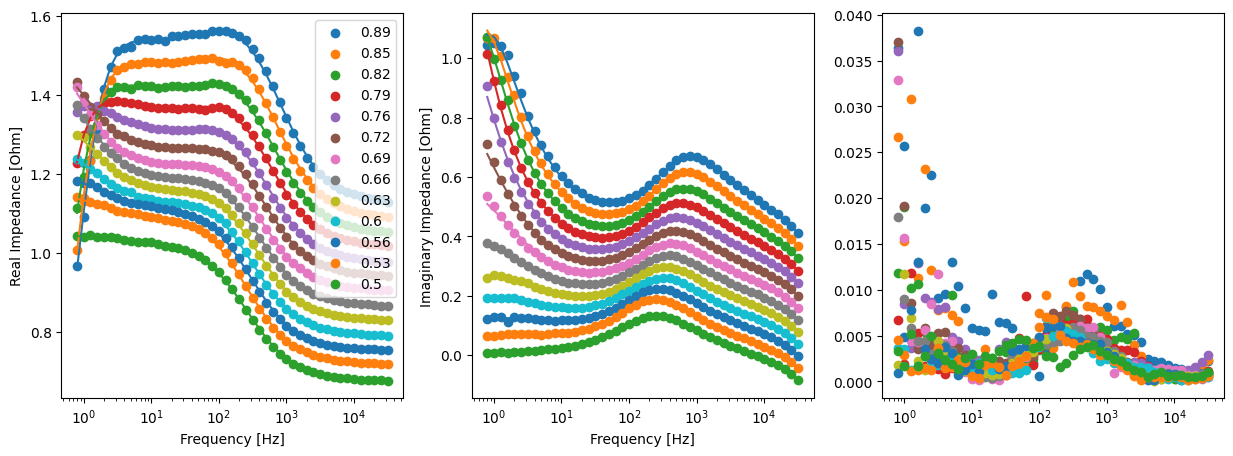

In [25]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].set_xscale('log')
axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_ylabel('Real Impedance [Ohm]')

axs[1].set_xscale('log')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Imaginary Impedance [Ohm]')

axs[2].set_xscale('log')

for i, key in reversed(list(enumerate(output.keys()))[::4]):
    cycle_output = output[key]

    Freq = cycle_output['Freq']/(2*np.pi)
    
    Z_exp_re = cycle_output['ReZ']
    Z_exp_im = cycle_output['ImZ']
    # Z_sim_re = np.matmul(cycle_output['A_re'],cycle_output['x'])
    # Z_sim_im = np.matmul(cycle_output['A_im'],cycle_output['x'])-np.exp(-cycle_output['f_m'])*cycle_output['C']

    Z_sim_re, Z_sim_im = Fit_Function_1(cycle_output['params'], cycle_output['A_re'], cycle_output['A_im'], cycle_output['f_m'])


    res = np.sqrt((Z_exp_re-Z_sim_re)**2 + (Z_exp_im-Z_sim_im)**2)

    offset = 0.01*i

    axs[0].scatter(Freq, Z_exp_re+offset, label = round(Electrode_Potential[i],2))
    axs[0].plot(Freq, Z_sim_re+offset)
    axs[1].scatter(Freq, Z_exp_im+offset)
    axs[1].plot(Freq, Z_sim_im+offset)

    axs[2].scatter(Freq,res)

axs[0].legend()

plt.savefig('figures/bodeplot.png')

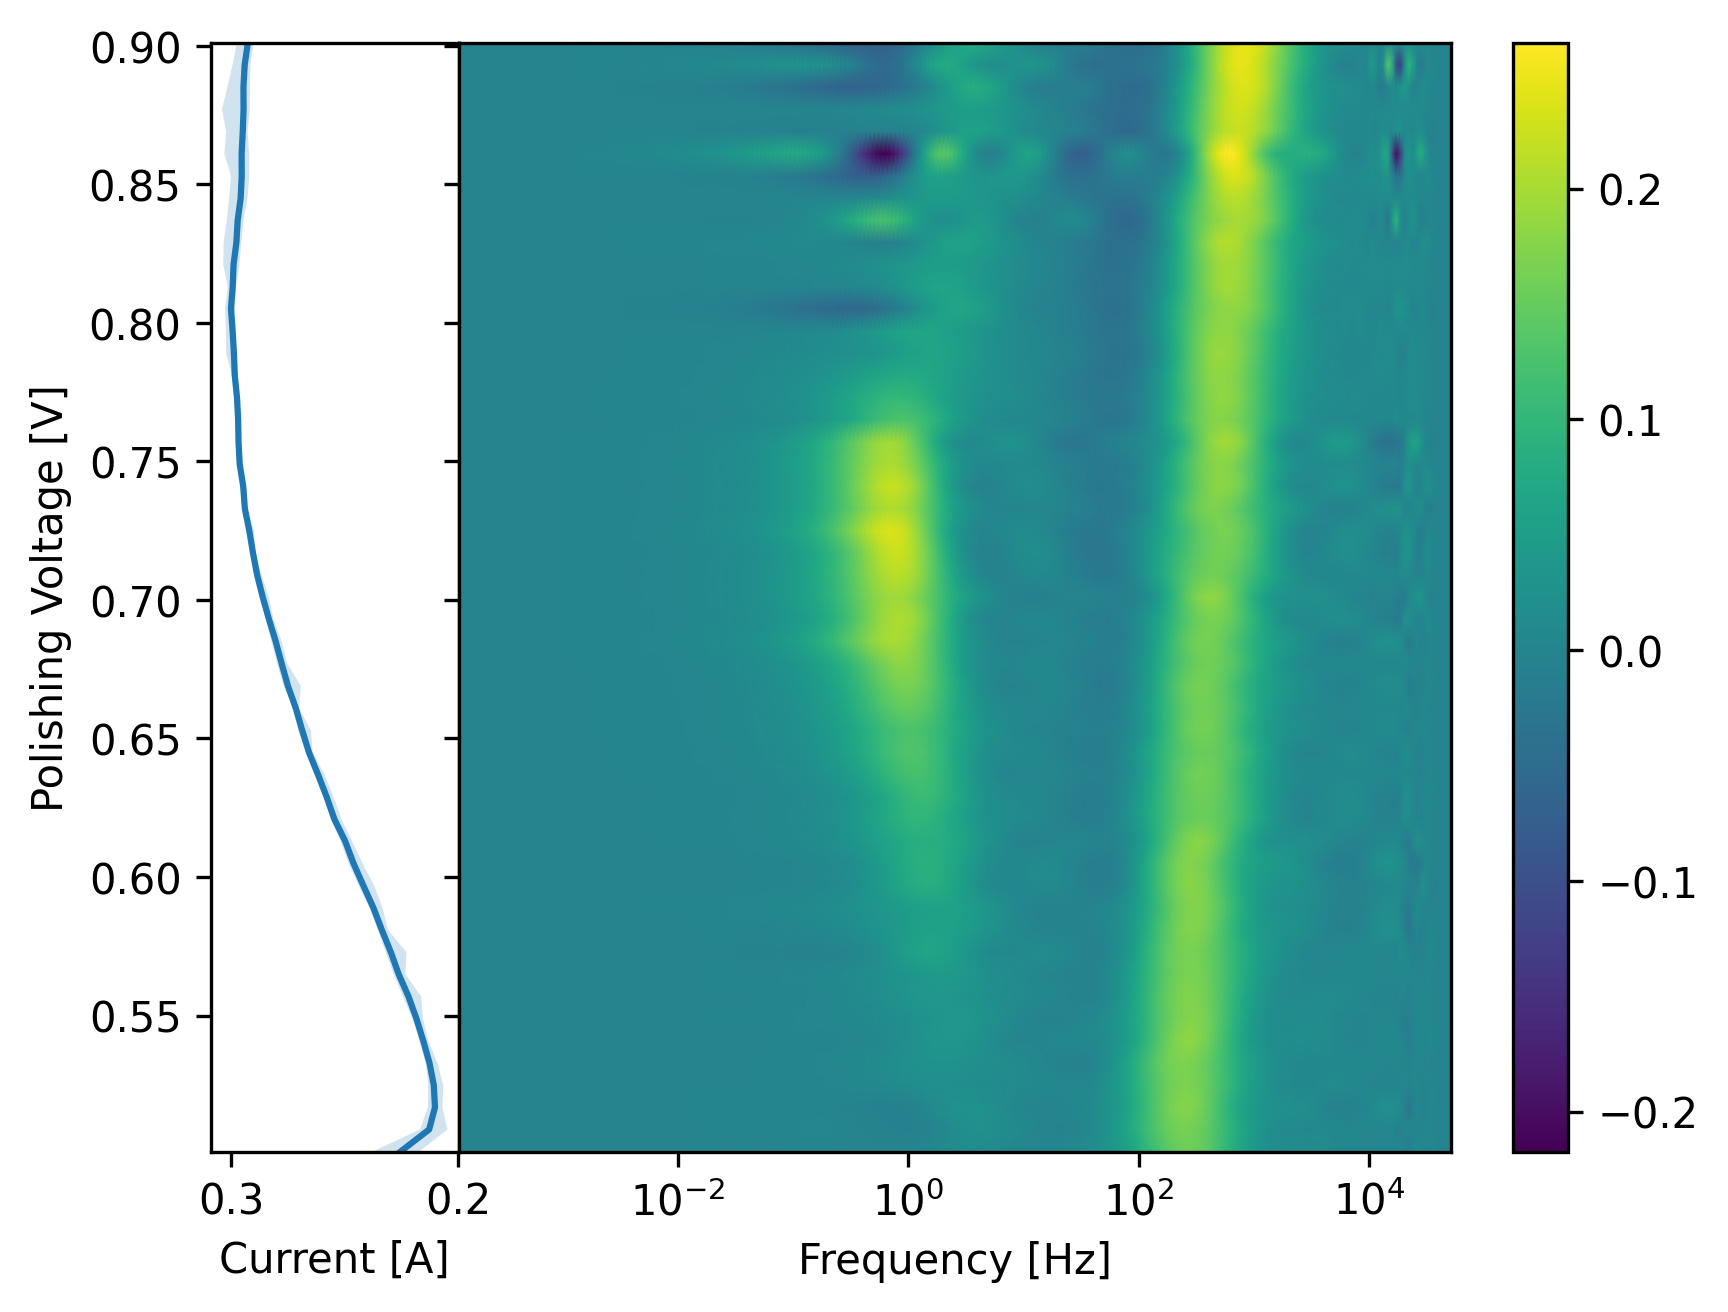

In [26]:

"""Plotting"""

# Plot gamma functions
#Params
plot_freq_min = np.min(Freq)/1000
plot_freq_max = np.max(Freq)*10
plot_points_per_decade = 12


#Convert to log
log_plot_freq_min = np.log(plot_freq_min)
log_plot_freq_max = np.log(plot_freq_max)
plot_points = int(plot_points_per_decade*(log_plot_freq_max-log_plot_freq_min))

#Generate plotting frequencies
log_plot_freq = np.linspace(log_plot_freq_min,log_plot_freq_max,plot_points)

plot_freq = np.exp(log_plot_freq)


gamma = np.sum(x[None,:,:]*Gaussian_Func(log_plot_freq[:,None,None]-log_f_n[None,:,None],gaussian_width),axis=1)

fig, (ax1, ax2) = plt.subplots(ncols=2,dpi=300,sharey=True,gridspec_kw={'width_ratios': [1, 5]})

X,Y = np.meshgrid(plot_freq/(2*np.pi),Electrode_Potential,indexing='ij')

mesh = ax2.pcolormesh(X,Y,gamma,shading='gouraud', cmap='viridis')
cbar = fig.colorbar(mesh)
#for i in range(gamma.shape[1]):
#    ax2.plot(plot_freq,gamma[:,i])

ax2.set_xscale('log')
ax2.set_xlabel('Frequency [Hz]')
#ax2.set_xticks([1e1,1e3,1e5])


ax1.plot(Current/1000,Electrode_Potential)
ax1.fill_betweenx(Electrode_Potential, Current_min/1000, Current_max/1000, alpha = 0.2)
ax1.set_ylabel('Polishing Voltage [V]')
ax1.set_xlabel('Current [A]')
ax1.invert_xaxis()
# ax1.set_xticks([0.1,0.2])
#ax1.set_yticks(np.arange(0.5,1.0,0.1))
# ax1.set_xlim(0.2,0)

fig.subplots_adjust(wspace = 0)

plt.savefig('figures/gamma.png')


In [27]:
from scipy.optimize import fsolve

def gamma_n(y,x,log_f_n,gaussian_width,n):

    return np.sum(x[None,:]*Gaussian_Derivative(y[:,None]-log_f_n[None,:],n,gaussian_width),axis=1)




#fig, (ax1, ax2) = plt.subplots(ncols=2,dpi=300,sharey=True,gridspec_kw={'width_ratios': [1, 5]})

#X,Y = np.meshgrid(plot_freq,Electrode_Potential,indexing='ij')

#mesh = ax2.pcolormesh(X,Y,d_gamma,shading='auto', cmap='viridis')
#mesh.set_norm(SymLogNorm(linthresh=1e0,vmin=0,vmax=100))
#cbar = fig.colorbar(mesh)

all_peaks = []
E_peaks = []
gamma_peaks = []
dd_gamma_peaks = []

for i in range(x.shape[-1]):

    f_gamma = lambda y: np.sum(x[None,:,i]*Gaussian_Derivative(y[:,None]-log_f_n[None,:],0,gaussian_width),axis=1)

    f_d_gamma = lambda y: np.sum(x[None,:,i]*Gaussian_Derivative(y[:,None]-log_f_n[None,:],1,gaussian_width),axis=1)

    f_dd_gamma = lambda y: np.sum(x[None,:,i]*Gaussian_Derivative(y[:,None]-log_f_n[None,:],2,gaussian_width),axis=1)*np.identity(y.shape[0])

    gamma = f_gamma(log_plot_freq)
    #gamma = gamma_n(log_plot_freq,x[:,-1],log_f_n,gaussian_width,0)


    d_gamma = f_d_gamma(log_plot_freq)
    #d_gamma = gamma_n(log_plot_freq,x[:,-1],log_f_n,gaussian_width,1)

    roots = fsolve(f_d_gamma, log_plot_freq, fprime=f_dd_gamma, maxfev=1000,factor=0.0001)
    roots = roots[(roots<log_plot_freq_max) & (roots>log_plot_freq_min)]
    roots = roots[np.abs(f_gamma(roots))>1e-2]
    roots = roots[np.abs(f_d_gamma(roots))<1e-4]
    a, ind = np.unique((roots).round(decimals=0),return_index=True)
    roots = roots[ind]

    E_roots = np.ones(roots.shape)*Electrode_Potential[i]
    gamma_peaks += f_gamma(roots).tolist()
    dd_gamma_peaks += np.sum(f_dd_gamma(roots),axis=-1).tolist()

    #ax2.plot(plot_freq,gamma)
    #ax2.plot(plot_freq,f_d_gamma(log_plot_freq))
    #ax2.plot(plot_freq,1e1*np.sum(f_dd_gamma(log_plot_freq),axis=1))
    #ax2.plot(plot_freq,1e1*np.gradient(f_d_gamma(log_plot_freq)))
    
    all_peaks += roots.tolist()
    E_peaks += E_roots.tolist()

all_peaks = np.array(all_peaks)
E_peaks = np.array(E_peaks)
gamma_peaks = np.array(gamma_peaks)
dd_gamma_peaks = np.array(dd_gamma_peaks)



#ax2.set_xscale('log')
#ax2.set_xlabel('Frequency [rad/s]')
#ax2.set_xticks([1e1,1e3,1e5])
#ax2.set_xlim(plot_freq_min,plot_freq_max)
#plt.grid(which='major')


#ax1.plot(Current/1000,Electrode_Potential)
#ax1.fill_betweenx(Electrode_Potential, Current_min/1000, Current_max/1000, alpha = 0.2)
#ax1.set_ylabel('Polishing Voltage [V]')
#ax1.set_xlabel('Current [A]')
#ax1.invert_xaxis()
# ax1.set_xticks([0.1,0.2])
#ax1.set_yticks(np.arange(0.5,1.0,0.1))
# ax1.set_xlim(0.2,0)

#fig.subplots_adjust(wspace = 0)

/home/viklund/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/viklund/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


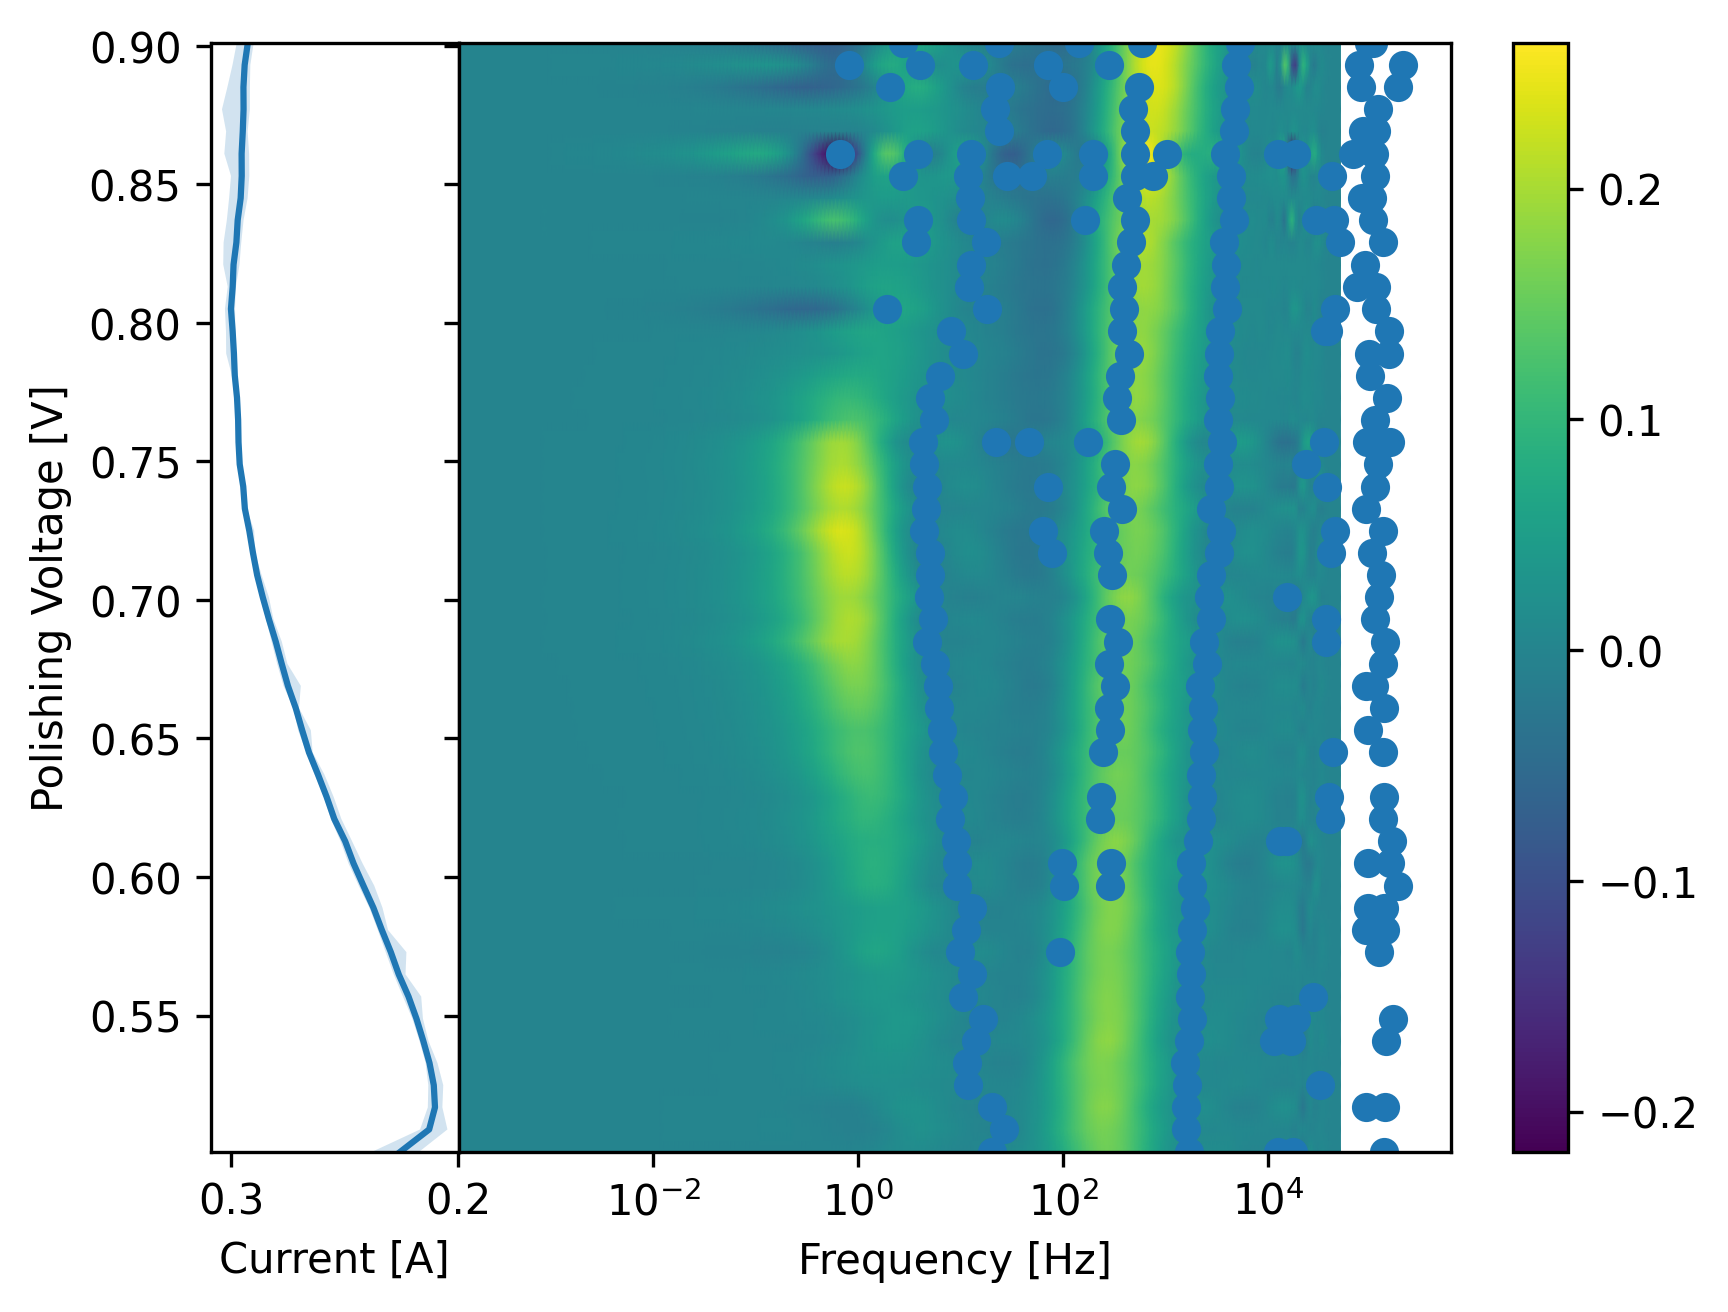

In [28]:
ax2.scatter(np.exp(all_peaks),E_peaks)

fig

/tmp/ipykernel_20959/4219122619.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1e5)
/tmp/ipykernel_20959/4219122619.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1e5)


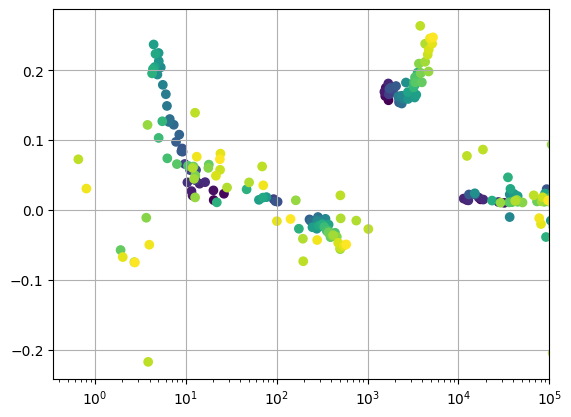

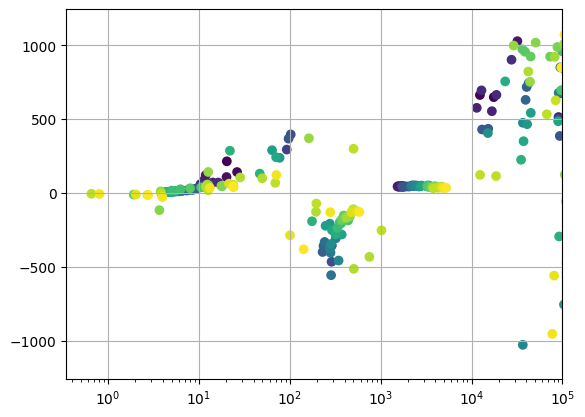

In [29]:
plt.figure()
plt.scatter(np.exp(all_peaks),gamma_peaks,c=E_peaks)
plt.xscale('log')
plt.xlim(0,1e5)
plt.grid('both')

R_peak = gamma_peaks
C_peak = all_peaks/R_peak

plt.figure()
plt.scatter(np.exp(all_peaks),C_peak,c=E_peaks)
plt.xscale('log')
plt.xlim(0,1e5)
plt.grid('both')

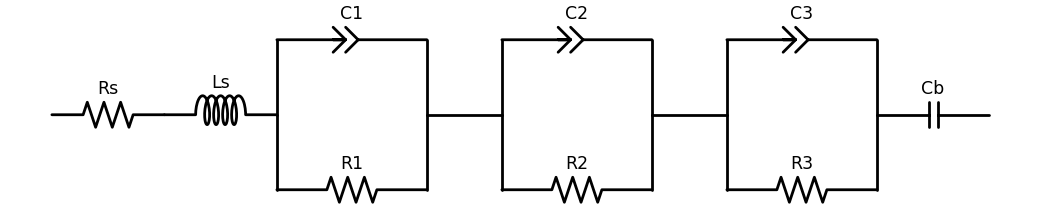

In [30]:
import schemdraw
import schemdraw.elements as elm



with schemdraw.Drawing() as d:
    Rs = d.add(elm.Resistor().label('Rs').length(d.unit*0.75))
    Ls = d.add(elm.Inductor2().label('Ls').length(d.unit*0.75))
    d.push()
    d += elm.Line().length(d.unit*0.5).up()
    C1 = d.add(elm.CPE().label('C1').right())
    d += elm.Line().length(d.unit*0.5).down()
    d.pop()
    d += elm.Line().length(d.unit*0.5).down()
    R1 = d.add(elm.Resistor().label('R1').right())
    d += elm.Line().length(d.unit*0.5).up()
    d += elm.Line().length(d.unit*0.5).right()
    d.push()
    d += elm.Line().length(d.unit*0.5).up()
    C2 = d.add(elm.CPE().label('C2').right())
    d += elm.Line().length(d.unit*0.5).down()
    d.pop()
    d += elm.Line().length(d.unit*0.5).down()
    R2 = d.add(elm.Resistor().label('R2').right())
    d += elm.Line().length(d.unit*0.5).up()
    d += elm.Line().length(d.unit*0.5).right()
    d.push()
    d += elm.Line().length(d.unit*0.5).up()
    C3 = d.add(elm.CPE().label('C3').right())
    d += elm.Line().length(d.unit*0.5).down()
    d.pop()
    d += elm.Line().length(d.unit*0.5).down()
    R3 = d.add(elm.Resistor().label('R3').right())
    d += elm.Line().length(d.unit*0.5).up()
    Cb = d.add(elm.Capacitor().label('Cb').length(d.unit*0.75).right())

    d.save('figures/ec.png')